# SVM с жёстким зазором (hard-margin SVM)

## Подрубаем библиотеки

In [1]:
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

## Алгоритм

Здесь и далее w*x = w1 * x1  +  w2 * x2  +  ...  +  wn * 1

- margin = y(w*x) --> max

- Hinge_loss = 0.5w*w+max(1-y(w*x),0) --> min

hard-margin:
 - уравнение полосы разделения: -1<w*x<1 
 - никакие объекты из трейновой выборки не должны попадать на полосу разделения.
 
Изменение весов:
 - w = w - C * w (правильная классификация, ywx > 1)
 - w = w - step*(y * x  -  C * w) (неправильная классификация, ywx < 0 << 1)

In [2]:
def add_bias_feature(a):
    a_extended = np.zeros((a.shape[0],a.shape[1]+1))
    a_extended[:,:-1] = a
    a_extended[:,-1] = int(1)  
    return a_extended


class CustomSVM(object):
    
    __class__ = "CustomSVM"
    __doc__ = """
    This is an implementation of the SVM classification algorithm
    Note that it works only for binary classification
    
    #############################################################
    ######################   PARAMETERS    ######################
    #############################################################
    
    etha: float(default - 0.01)
        Learning rate, gradient step
        
    alpha: float, (default - 1.0)
        Regularization parameter in 0.5*alpha*||w||^2
        
    epochs: int, (default - 200)
        Number of epochs of training
      
    #############################################################
    #############################################################
    #############################################################
    """
    
    def __init__(self, etha=0.01, alpha=0.1, epochs=200):
        
        self._epochs = epochs
        self._etha = etha
        self._alpha = alpha
        
        self._w = None
        self.fit_n_errors = None
        self.fit_loss = None
    

    def fit(self, X, Y, verbose=False): #arrays: X; Y =-1,1
        
        if len(set(Y)) != 2:
            raise ValueError("Number of classes in Y is not equal 2!")
        
        X_extended = add_bias_feature(X) 
        self._w = np.random.normal(loc=0, scale=0.05, size=X_extended.shape[1])
        errors = []
        loss_epoch = []
        
        for epoch in range(self._epochs):
            err = 0
            loss = 0
            for i,x in enumerate(X_extended):
                prod = np.dot(self._w,X_extended[i])
                if Y[i]*prod >= 1: # классифицируем верно
                    self._w = self._w - self._etha*self._alpha*self._w/self._epochs
                else: # классифицируем неверно
                    self._w = self._w + self._etha*(Y[i]*X_extended[i] - self._alpha*self._w/self._epochs)
                    err += 1
                    loss += self._hinge(X_extended[i],Y[i])
            
            if verbose:
                print('epoch {}. Errors={}. Mean Hinge_loss={}'.format(epoch,err,loss/X_extended.shape[0]))
            errors.append(err)
            loss_epoch.append(loss/X_extended.shape[0])
            
        self.fit_n_errors = np.array(errors)
        self.fit_loss = np.array(loss_epoch)
            

    def predict(self, X:np.array) -> np.array:
        y_pred = []
        X_extended = add_bias_feature(X)
        for i in range(len(X_extended)):
            y_pred.append(np.sign(np.dot(self._w,X_extended[i])))
        return np.array(y_pred)
    
    
    def _hinge(self, x, y):
        return max(0,1 - y*np.dot(x, self._w))

## Демонстрируем, что работает:

In [3]:
# блок подготовки данных
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
Y = iris.target

pca = PCA(n_components=2)
X = pca.fit_transform(X)
Y = (Y > 0).astype(int)*2-1 # [0,1,2] --> [False,True,True] --> [0,1,1] --> [0,2,2] --> [-1,1,1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=2020)

[52 21 14 10  9  7  5  6  5  4  4  4  4  4  4  4  3  3  2  1  2  1  2  1
  2  1  2  1  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2
  1  2  1  2  1  2  1  2  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  0  0
  0  0  0  0  0  0]
[ 0.96293279 -0.86146291  1.23481335]


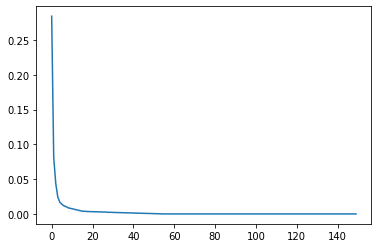

In [4]:
# блок инициализиции и обучения
svm = CustomSVM(etha=0.01, alpha=0.05, epochs=150)
svm.fit(X_train, Y_train)


print(svm.fit_n_errors) # numbers of error in each epoch
#print(svm.fit_loss)
print(svm._w) # w0*x_i[0]+w1*x_i[1]=w2

plt.plot(svm.fit_loss)
plt.show()

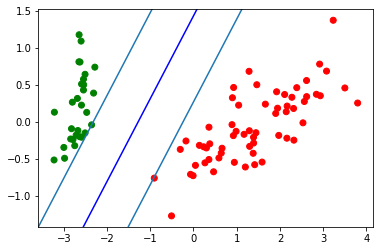

In [5]:
# блок
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def newline(p1, p2, color=None):
    #function kredits to: https://fooobar.com/questions/626491/how-to-draw-a-line-with-matplotlib
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax], color=color)
    ax.add_line(l)
    return l


d = {-1:'green', 1:'red'}
plt.scatter(X_train[:,0], X_train[:,1], c=[d[y] for y in Y_train])
newline([0,-svm._w[2]/svm._w[1]],[-svm._w[2]/svm._w[0],0], 'blue') # в w0*x_i[0]+w1*x_i[1]+w2*1=0 поочередно
                                                        # подставляем x_i[0]=0, x_i[1]=0
newline([0,1/svm._w[1]-svm._w[2]/svm._w[1]],[1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=1
newline([0,-1/svm._w[1]-svm._w[2]/svm._w[1]],[-1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=-1
plt.show()

#### Убеждаемся, что все объекты из отложенной выборки классифицируются правильно

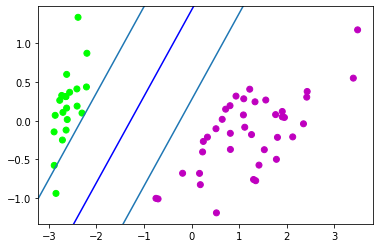

In [6]:
# предсказываем после обучения
y_pred = svm.predict(X_test)

d1 = {-1:'lime', 1:'m'}
plt.scatter(X_test[:,0], X_test[:,1], c=[d1[y] for y in y_pred])
newline([0,-svm._w[2]/svm._w[1]],[-svm._w[2]/svm._w[0],0], 'blue')
newline([0,1/svm._w[1]-svm._w[2]/svm._w[1]],[1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=1
newline([0,-1/svm._w[1]-svm._w[2]/svm._w[1]],[-1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=-1
plt.show()

### Далее:
 - алгоритм с мягким зазором (soft-margin SVM) при линейно неразделимых данных. Позволим алгоритму допускать ошибки на обучающих объектах, но при этом постараемся, чтобы ошибок было поменьше. Сделаем пример на том же датасете Ирис, для классов 1 и 2 (до этого отделяли класс 0 от 1+2)